# Pulse Optimized Scrambling Demo

References: 

- **"Qiskit pulse: programming quantum computers through the cloud with pulses"**; Thomas Alexander et al 2020 Quantum Sci. Technol. 5 044006; Source code: https://zenodo.org/record/3751565#.YLIrG_kzZEY
- **"Optimized Quantum Compilation for Near-Term Algorithms with OpenPulse"**; arXiv:2004.11205 [quant-ph]; Source code: https://github.com/singular-value/optimizations_via_openpulse

In [1]:
# general imports:
%matplotlib inline
import matplotlib, qiskit, pprint, itertools
from matplotlib import pyplot as plt
import numpy as np
from numpy import pi
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, IBMQ, transpile, schedule, assemble
from qiskit.circuit import *
from qiskit.circuit.library.standard_gates import *
from qiskit.providers.aer import QasmSimulator
from qiskit.test.mock import FakeAlmaden, FakeMontreal
from qiskit.visualization import *
from qiskit.circuit.library import *
from qiskit.pulse import *

In [2]:
from pulse_rx_utils import *

In [3]:
# import utils for Quantum Information Scrambling Verification Test:
from QSVT_utils import *

from pulse_utils import *

In [4]:
# load account:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

# get simulator:
f_alma = FakeAlmaden() # simulator f_alma for pulse schedules
f_mon = FakeMontreal()

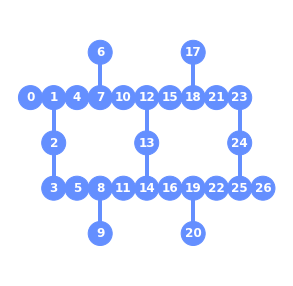

In [5]:
backend = f_mon # set simulator

# get defaults and instruction schedule map 
backend_config = backend.configuration()
ham_params = backend_config.hamiltonian['vars']
dt = backend_config.dt
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map 

# get dict with control channels and cr pulses for all coupled pairs
CR_dict = get_CR_dict(backend)

plot_gate_map(f_mon)

In [6]:
q0, q1, q2, q3, q4, q5, q6 = 3, 5, 8, 11, 14, 13, 12

# Functions

In [7]:
def get_direct_rx_schedule_n(theta, qubit_index, backend):
    circ_inst_map = backend.defaults().instruction_schedule_map 
    x_instructions = circ_inst_map.get('x', qubits=[qubit_index]).instructions
    assert len(x_instructions) == 1
    x_samples = x_instructions[0][1].pulse.get_waveform().samples
    
    area_under_curve = sum(map(np.real, x_samples))
    
    if theta > np.pi:
        theta -= 2 * np.pi
    
    direct_rx_samples = rescale_samples(x_samples, (theta / np.pi))
    direct_rx_samplepulse = Waveform(direct_rx_samples).samples
    direct_rx_command = Play(Waveform(direct_rx_samplepulse),(backend.configuration().drive(qubit_index)))
    return Schedule([0, direct_rx_command])

In [18]:
def get_CR_theta_sched(theta,control,target,backend):

    inst_sched_map = backend.defaults().instruction_schedule_map 
    cx_instructions = inst_sched_map.get('cx', qubits=[control, target]).instructions
    xc_instructions = inst_sched_map.get('cx', qubits=[target, control]).instructions

    cr_uchan, cr_pulse = get_CRs(q1,q2,backend)

    inst_sched_map = backend.defaults().instruction_schedule_map 
    cx_instructions = inst_sched_map.get('cx', qubits=[control, target]).instructions
    xc_instructions = inst_sched_map.get('cx', qubits=[target, control]).instructions

    cr_control_inst = [(y.pulse,y.channel) for (x,y) in cx_instructions if type(y.channel)==ControlChannel and type(y)==Play]

    cr_drive_inst = [(y.pulse,y.channel) for (x,y) in cx_instructions if type(y.channel)==DriveChannel and type(y)==Play and type(y.pulse)==GaussianSquare]


    cr_control_inst = cr_control_inst[0]  # driving of control qubit at target's frequency
    cr_drive_inst = cr_drive_inst[0] # active cancellation tone

    flip = False

    if theta < 0:
        flip = True
        theta = -1 * theta

    if theta > 2 * np.pi:
        theta -= 2 * np.pi

    cr_uchan, cr_pulse = get_CRs(q1,q2,backend)

    full_area_under_curve = sum(map(np.real, cr_pulse.get_waveform().samples))
    target_area_under_curve = full_area_under_curve * (theta / (np.pi / 2))

    # CR pulse samples have gaussian rise, flattop, and then gaussian fall.
    # we want to find the start and end indices of the flattop
    flat_start = 0
    while cr_pulse.get_waveform().samples[flat_start] != cr_pulse.get_waveform().samples[flat_start + 1]:
        flat_start += 1
    assert cr_pulse.get_waveform().samples[flat_start] == cr_pulse.get_waveform().samples[flat_start + 1]

    flat_end = flat_start + 1
    while cr_pulse.get_waveform().samples[flat_end] == cr_pulse.get_waveform().samples[flat_end + 1]:
        flat_end += 1
    assert cr_pulse.get_waveform().samples[flat_end] == cr_pulse.get_waveform().samples[flat_end - 1]

    area_under_curve = sum(map(np.real, cr_pulse.get_waveform().samples[:flat_start]))
    area_under_curve += sum(map(np.real, cr_pulse.get_waveform().samples[flat_end+1:]))
    flat_duration = (target_area_under_curve - area_under_curve) / np.real(cr_pulse.get_waveform().samples[flat_start])
    flat_duration = max(0, int(flat_duration + 0.5))
    duration = len(cr_pulse.get_waveform().samples[:flat_start]) + flat_duration + len(cr_pulse.get_waveform().samples[flat_end+1:])
    if duration % 16 <= 8 and flat_duration > 8:
        flat_duration -= duration % 16
    else:
        flat_duration += 16 - (duration % 16)

    cr_drive_samples = np.concatenate([
        cr_pulse.get_waveform().samples[:flat_start],
        [cr_pulse.get_waveform().samples[flat_start]] * flat_duration,
        cr_pulse.get_waveform().samples[flat_end+1:]
    ])

    cr_control_samples = np.concatenate([
        cr_pulse.get_waveform().samples[:flat_start],
        [cr_pulse.get_waveform().samples[flat_start]] * flat_duration,
        cr_pulse.get_waveform().samples[flat_end+1:]
    ])

    assert len(cr_drive_samples) % 16 == 0
    assert len(cr_control_samples) % 16 == 0

    current_area_under_curve = sum(map(np.real, cr_control_samples))
    scaling_factor = target_area_under_curve / current_area_under_curve

    cr_drive_samples *= scaling_factor
    cr_control_samples *= scaling_factor

    cr_p_schedule = Play(Waveform(cr_drive_samples), cr_drive_inst[1]) | Play(Waveform(cr_control_samples),cr_control_inst[1])
    cr_m_schedule = Play(Waveform(-1*cr_drive_samples),cr_drive_inst[1]) | Play(Waveform(-1*cr_control_samples),cr_control_inst[1])

    if flip:
        schedule = cr_m_schedule
        schedule |= inst_sched_map.get('x', qubits=[control]) << schedule.duration
        schedule |= cr_p_schedule << schedule.duration
    else:
        schedule = cr_p_schedule
        schedule |= inst_sched_map.get('x', qubits=[control]) << schedule.duration
        schedule |= cr_m_schedule << schedule.duration
    return schedule

# Schedule

In [19]:
alpha = 1

theta = get_theta_from_alpha(1)
beta = get_theta_from_alpha(alpha)

In [20]:
#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits scrambling unitary operates on
n = 3

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# inums of upper and lower half qubits
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# initial bell pair inums defining the many-body-system
bell_pairs = get_bell_pairs(qnum)

# list of all bell pairs that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# get pairs for two-qubit gates in scrambling protocol
upper_pairs, lower_pairs = get_unitary_pairs(qnum)

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = 0, qnum-1

# define qubit pair that will be used for base measurement 
# fist pair in the list is the middle pair (furthes away from bob and alice), but any pair will do
basemeas = meas_pairs[0]

In [21]:
backend = f_mon

cr = ClassicalRegister(7)
qr = QuantumRegister(7)
circ = QuantumCircuit(qr,cr)

circ = transpile(circ, f_mon,initial_layout=[q0, q1, q2, q3, q4, q5, q6])

q0, q1, q2, q3, q4, q5, q6 = 3, 5, 8, 11, 14, 13, 12

bellpairs = [[q2, q3], [q1, q4], [q5, q6]]

for pair in bellpairs:
    circ.h(pair[0])
    circ.cx(pair[0],pair[1])
    
tpcirc = transpile(circ, f_mon)

from qiskit import schedule
sched = schedule(tpcirc, f_mon)

# two qubit gates q0 - q2 & q5 - q3

# swaps
sched += inst_sched_map.get('cx',[q1,q2])
sched += inst_sched_map.get('cx',[q2,q1])
sched += inst_sched_map.get('cx',[q1,q2])

sched += inst_sched_map.get('cx',[q3,q4])
sched += inst_sched_map.get('cx',[q4,q3])
sched += inst_sched_map.get('cx',[q3,q4])

sched += get_CR_theta_sched(theta,q0,q1,backend)
sched += get_CR_theta_sched(beta,q5,q4,backend)

# back swaps
sched += inst_sched_map.get('cx',[q1,q2])
sched += inst_sched_map.get('cx',[q2,q1])
sched += inst_sched_map.get('cx',[q1,q2])

sched += inst_sched_map.get('cx',[q3,q4])
sched += inst_sched_map.get('cx',[q4,q3])
sched += inst_sched_map.get('cx',[q3,q4])

# two qubit gates q0 - q1 & q5 - qq4

sched += get_CR_theta_sched(theta,q0,q1,backend)
sched += get_CR_theta_sched(theta,q5,q4,backend)

# two qubit gates q1 - q2 & q3 - q4

sched += get_CR_theta_sched(theta,q1,q2,backend)
sched += get_CR_theta_sched(theta,q3,q4,backend)

# single q rotations

for q in [q0, q1, q2]:
    sched += get_direct_rx_schedule_n(theta, q, f_mon)
    
for q in [q3, q4, q5]:
    sched += get_direct_rx_schedule_n(theta, q, f_mon)
    
# two qubit gates q0 - q2 & q5 - q3

# swaps
sched += inst_sched_map.get('cx',[q1,q2])
sched += inst_sched_map.get('cx',[q2,q1])
sched += inst_sched_map.get('cx',[q1,q2])

sched += inst_sched_map.get('cx',[q3,q4])
sched += inst_sched_map.get('cx',[q4,q3])
sched += inst_sched_map.get('cx',[q3,q4])

sched += get_CR_theta_sched(theta,q0,q1,backend)
sched += get_CR_theta_sched(theta,q5,q4,backend)

# back swaps
sched += inst_sched_map.get('cx',[q1,q2])
sched += inst_sched_map.get('cx',[q2,q1])
sched += inst_sched_map.get('cx',[q1,q2])

sched += inst_sched_map.get('cx',[q3,q4])
sched += inst_sched_map.get('cx',[q4,q3])
sched += inst_sched_map.get('cx',[q3,q4])


In [22]:
qr = QuantumRegister(7)
circ = QuantumCircuit(qr,cr)
circ = transpile(circ, f_mon,initial_layout=[q0, q1, q2, q3, q4, q5, q6])
bellpairs = [[q2, q3], [q1, q4], [q5, q6]]

for pair in bellpairs:
    circ.cx(pair[0],pair[1])
    circ.h(pair[0])
    
circ.measure_all()

tpcirc = transpile(circ, f_mon)

from qiskit import schedule
end_sched = schedule(tpcirc, f_mon)

In [23]:
sched += end_sched

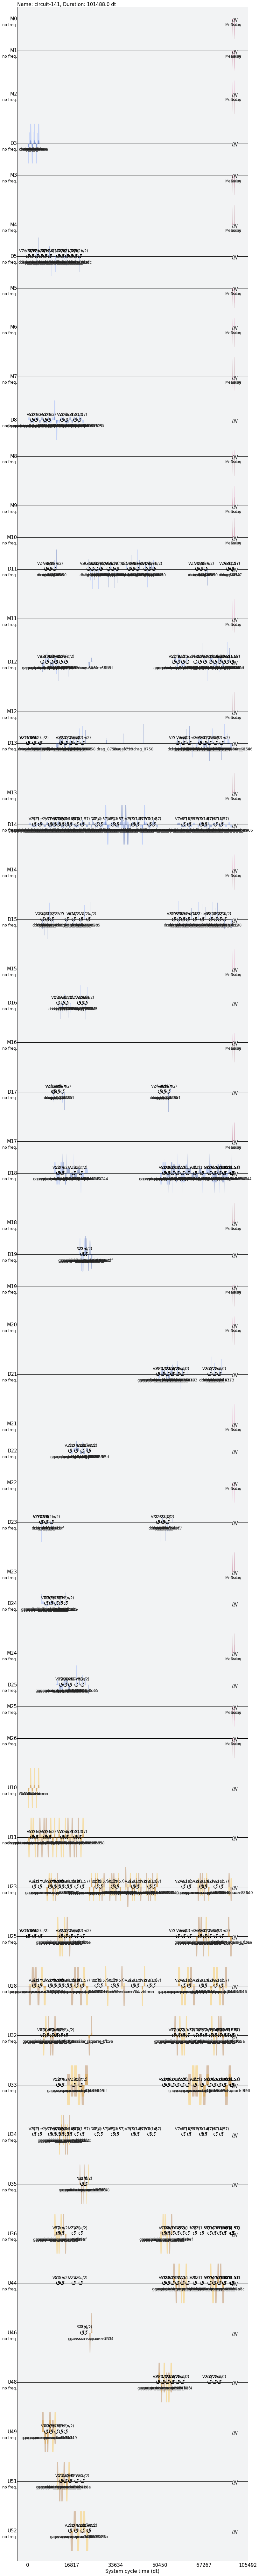

In [24]:
sched.draw()

In [34]:
qobj = assemble(sched,backend=f_mon, shots=1)

In [35]:
res = f_mon.run(qobj).result()

MemoryError: Unable to allocate 52.0 GiB for an array with shape (387420489, 9) and data type complex128